# CNN Classification
Using the cifar - 10 dataset to practice classification

Max Pooling
![alt text](images/maxpool.png "Title")

In [49]:

#imports
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [50]:
if torch.cuda.is_available():
    print("CUDA is available! Using CUDA as device.")
    device = torch.device('cuda')
else:
    print("CUDA is not available, using CPU as device.")
    device = torch.device('cpu')

CUDA is available! Using CUDA as device.


In [51]:
#Hyper-parameters
num_epocs = 10
batch_size = 100
learning_rate = 0.01

In [52]:
deftransform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

trainingset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                           download = True, transform=deftransform)
trainloader= torch.utils.data.DataLoader(trainingset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

validationset= torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download= True, transform=deftransform)

validationloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size,
                                               shuffle = True, num_workers = 2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', ' dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


tensor([7, 5, 9, 8, 1, 1, 8, 0, 6, 1, 1, 0, 9, 4, 0, 8, 1, 0, 1, 7, 8, 5, 3, 2,
        5, 0, 4, 9, 9, 4, 1, 3, 0, 2, 2, 7, 4, 0, 6, 3, 9, 4, 2, 2, 4, 4, 3, 7,
        9, 3, 5, 0, 7, 3, 5, 1, 2, 5, 2, 7, 5, 3, 7, 9, 5, 3, 9, 6, 0, 7, 7, 4,
        4, 7, 2, 9, 4, 5, 7, 1, 3, 9, 8, 3, 3, 1, 2, 4, 3, 7, 2, 2, 4, 8, 7, 4,
        2, 6, 6, 6])
horse   dog truck  ship


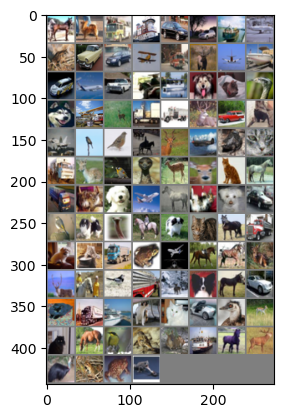

In [53]:

def showimage(img):
    img = img /2 + 0.5
    npimp = img.numpy()
    plt.imshow(np.transpose(npimp,(1,2,0)))
    plt.show
    
dataiter = iter(trainloader)
images, labels = next(dataiter)

showimage(torchvision.utils.make_grid(images))
print(labels)
print(' '.join('%5s' % classes[labels[j]] for j in range (4)))

In [54]:
## make neural network that begins from nn.Module

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,3,1, padding=1) #input color image 3 channel, 16 filters padding 1 to remove all edge fileters
        self.conv2 = nn.Conv2d(16,32,3,1, padding=1) # double feature maps
        self.conv3 = nn.Conv2d(32,64,3,1, padding=1)
        self.fc1 = nn.Linear(4*4*64, 500) #after three maxpooling layers it reduces to 4*4
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(500,10) #need 10 possible outps
    def forward(self,x):
        x = F.relu(self.conv1(x)) #apply relu to each output of conv layer (normalization)
        x = F.max_pool2d(x,2,2) # max pooling layer with kernel 2 and stride 2
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1, 4*4*64) # flattening the images to a 1d output
        x = F.relu(self.fc1(x))
        x = self.dropout1(x) ## applying droput b/t layers
        x = self.fc2(x)
        return x
    
print(device)
net = Net().to(device)

cuda


# Define a loss function and optimizer

in this case since it's a classification model, using a cross entropy loss will work and using stochastic gradient descent

In [55]:
import torch.optim as optim

lossfxn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

In [56]:
epochs = 15
running_loss_history=[]
running_corrects_history=[]
val_running_loss_history=[]
val_running_corrects_history=[]

for e in range(epochs):
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs=net(inputs)
        loss = lossfxn(outputs,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs,1)
        
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
    with torch.no_grad():
        for val_inputs, val_labels in validationloader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = net(val_inputs)
            val_loss = lossfxn(val_outputs, val_labels)
            
            _, val_preds = torch.max(val_outputs, 1)
            val_running_loss += val_loss.item()
            val_running_corrects += torch.sum(val_preds == val_labels.data)
            
        epoch_loss = running_loss/(len(trainloader) * batch_size)
        epoch_acc = running_corrects.float()/(len(trainloader)*batch_size)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc.cpu().numpy())
        
        val_epoch_loss = val_running_loss/(len(validationloader) * batch_size)
        val_epoch_acc = val_running_corrects.float()/(len(validationloader)* batch_size)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc.cpu().numpy())
        
        print('epoch: ', (e+1))
        print('training loss: {:.4f}, acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, acc {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

        

epoch:  1
training loss: 0.0186, acc 0.3141
validation loss: 0.0158, acc 0.4299
epoch:  2
training loss: 0.0135, acc 0.5126
validation loss: 0.0126, acc 0.5581
epoch:  3
training loss: 0.0113, acc 0.5982
validation loss: 0.0107, acc 0.6143
epoch:  4
training loss: 0.0099, acc 0.6504
validation loss: 0.0097, acc 0.6619
epoch:  5
training loss: 0.0087, acc 0.6918
validation loss: 0.0093, acc 0.6789
epoch:  6
training loss: 0.0078, acc 0.7261
validation loss: 0.0088, acc 0.6924
epoch:  7
training loss: 0.0071, acc 0.7517
validation loss: 0.0083, acc 0.7135
epoch:  8
training loss: 0.0063, acc 0.7759
validation loss: 0.0084, acc 0.7148
epoch:  9
training loss: 0.0056, acc 0.8021
validation loss: 0.0085, acc 0.7188
epoch:  10
training loss: 0.0051, acc 0.8191
validation loss: 0.0084, acc 0.7287
epoch:  11
training loss: 0.0044, acc 0.8431
validation loss: 0.0089, acc 0.7283
epoch:  12
training loss: 0.0039, acc 0.8609
validation loss: 0.0095, acc 0.7154
epoch:  13
training loss: 0.0033, acc

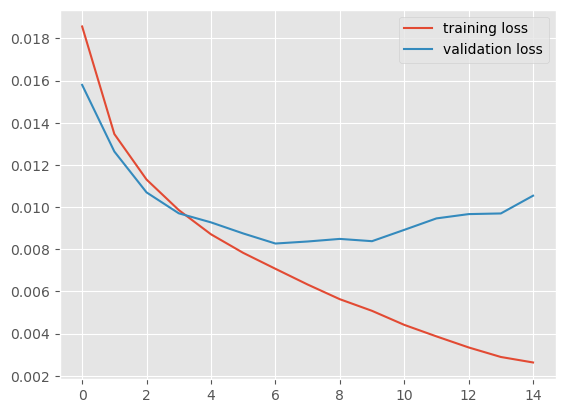

In [57]:
plt.style.use('ggplot')
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

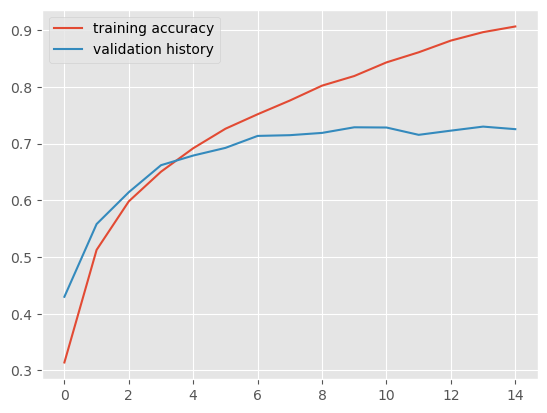

In [59]:
plt.style.use('ggplot')
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation history')
plt.legend()